# LangGraph implementation


In [4]:
import os

os.chdir("/Users/Anaqi_Amir/Desktop/FlavorFusion/api/src")

from langchain_core.tools import tool
from langchain_openai.chat_models import ChatOpenAI

from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver

from nlp.NLSPipeline import extract_nutritional_features
from models.dev.faiss_indexes import FlatIndex

from dotenv import load_dotenv


# Load env
load_dotenv()

# Load index
index = FlatIndex("../../recipe_embeddings_small.json")

/Users/Anaqi_Amir/opt/anaconda3/envs/FlavorFusion/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2025-03-25 10:29:37.202275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Anaqi_Amir/opt/anaconda3/envs/FlavorFusion/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Define tools
@tool
def recommend_recipes(q: str) -> str:
    """Takes in user input, extracts relevant features, and output recommended recipes from database"""

    print(f"\n Parsed user input: \n {q} \n")

    extracted_features = extract_nutritional_features(q)

    print(f"\n Extracted features: \n {extracted_features} \n")

    recs = index.recommend_recipes(
        user_ingredients=extracted_features.user_ingredients,
        allergens=extracted_features.allergens,
        calories=extracted_features.calories,
        total_fat=extracted_features.total_fat,
        protein=extracted_features.protein,
        saturated_fat=extracted_features.saturated_fat,
        carbs=extracted_features.carbs,
        sodium=extracted_features.sodium,
        sugar=extracted_features.sugar,
        top_n=10,
    )

    print(f"\n recs: \n {recs} \n")

    return ", ".join(recs)


@tool
def final_answer(answer: str) -> str:
    """Useful for providing the final answer to the user."""
    print("Hi im the final answer")
    return answer


# Define tool node
tools = [recommend_recipes, final_answer]
tool_node = ToolNode(tools)  # A single node that contains all the tools


# Define llm
llm = ChatOpenAI().bind_tools(tools)


# Define nodes
def router(state: MessagesState):
    messages = state["messages"]
    print(f"Router: {messages}")
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "end"


def agent(state: MessagesState):
    messages = state["messages"]
    print(f"Agent: {messages}")
    response = llm.invoke(messages)
    return {"messages": [response]}


# Define graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", router, {"tools": "tools", "end": END})
workflow.add_edge("tools", "agent")

# Define memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

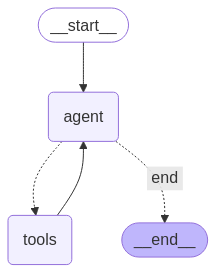

In [3]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
# IO
def stream_graph_updates(user_input: str):
    for event in app.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config={"configurable": {"thread_id": "1"}},
    ):
        entity = [list(event)[0]][0].upper()  # either agent or tool
        print(f"##### {entity} MESSAGE #####")
        print(event[list(event)[0]]["messages"][-1].content)
        print("\n")


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        print("##### HUMAN MESSAGE #####")
        print(user_input)
        print("\n")

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

##### HUMAN MESSAGE #####
hi there


Agent: [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='15c25751-326c-4082-b3f1-3e9817ea7330')]
Router: [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='15c25751-326c-4082-b3f1-3e9817ea7330'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 82, 'total_tokens': 93, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-d53c625b-be27-4997-8d93-b9589350be3c-0', usage_metadata={'input_tokens': 82, 'output_tokens': 11, 'total_tokens': 93, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_de

/Users/Anaqi_Amir/Desktop/FlavorFusion/api/src/nlp/NLSPipeline.py:91: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0.1, api_key=os.environ.get("OPENAI_API_KEY"))
/Users/Anaqi_Amir/Desktop/FlavorFusion/api/src/nlp/NLSPipeline.py:94: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=chat_prompt)



 Extracted features: 
 user_ingredients=['noodles'] allergens=['wheat'] calories=(None, None) total_fat=(None, None) saturated_fat=(None, None) carbs=(None, None) sugar=(None, None) sodium=(None, None) protein=(None, None) 


 recs: 
 ['hawaiian quesadillas', 'ez pasta bake', 'sakhons noodles', 'baked popcorn shrimp', 'homemade stromboli   mmmmmmmmmmm', 'ww easy chicken and rice', 'honey garlic pork chops', 'quick tuna no noodle casserole', 'crock pot pizza  easy enough for teens to make', 'stuffed kielbasa'] 

##### TOOLS MESSAGE #####
hawaiian quesadillas, ez pasta bake, sakhons noodles, baked popcorn shrimp, homemade stromboli   mmmmmmmmmmm, ww easy chicken and rice, honey garlic pork chops, quick tuna no noodle casserole, crock pot pizza  easy enough for teens to make, stuffed kielbasa


Agent: [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='15c25751-326c-4082-b3f1-3e9817ea7330'), AIMessage(content='Hello! How can I assist you today?', additional_